In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

#LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#PCA
from sklearn.decomposition import PCA

#Seaborn
import seaborn as sns


In [2]:
import optuna

file_path = '../cleaned_data3.csv'  # <-- แก้เอง

# Use existing df_all in the notebook if available, otherwise read CSV
if 'df_all' in globals():
    df_all_local = df_all.copy()
    print("Using existing df_all from notebook variables")
else:
    df_all_local = pd.read_csv(file_path)
    print(f"Loaded df_all from {file_path}")

# If the dataset is in long format (date_month, ind_code, value) pivot to wide.
# If it's already wide (like the provided cleaned_data2.csv), skip pivot.
if 'ind_code' in df_all_local.columns and 'value' in df_all_local.columns:
    # ensure date column name matches expectation
    if 'date_month' not in df_all_local.columns and 'year_month' in df_all_local.columns:
        df_all_local = df_all_local.rename(columns={'year_month': 'date_month'})
    # ลบ whitespace จาก ind_code
    df_all_local['ind_code'] = df_all_local['ind_code'].astype(str).str.strip()

    print("Available indicators:")
    print(sorted(df_all_local['ind_code'].unique()))
    print()

    df = df_all_local.pivot_table(
        index='date_month',
        columns='ind_code',
        values='value'
    ).reset_index()
else:
    # assume wide format; try to find date column
    if 'date_month' in df_all_local.columns:
        df = df_all_local.copy()
        date_col = 'date_month'
    elif 'year_month' in df_all_local.columns:
        df = df_all_local.copy().rename(columns={'year_month': 'date_month'})
        date_col = 'date_month'
    else:
        raise KeyError("No 'ind_code' column and no recognized date column ('date_month' or 'year_month') found in df_all.")

    print(f"Data treated as wide format. Columns: {sorted(df.columns.tolist())}\n")

print(f"Data loaded: {df.shape}")

# เตรียมข้อมูล
df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)
df = df.set_index(['date_month']).sort_index()
df = df.asfreq('MS')  # ตั้งความถี่เป็น Monthly Start

print("Data preparation completed\n")
df.info()

test_size = 18
train_data = df[:-test_size]
test_data = df[-test_size:]

print("\nTrain data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

df

Loaded df_all from ../cleaned_data3.csv
Data treated as wide format. Columns: ['china_pmi', 'china_pmi_lag12', 'china_pmi_lag6', 'china_pmi_ma12', 'china_pmi_ma6', 'china_pmi_std12', 'china_pmi_std6', 'date_month', 'domestic_consumption', 'exchange_rate_usd', 'exchange_rate_usd_pct12', 'exchange_rate_usd_pct6', 'export_volume', 'import_volume', 'is_season', 'month', 'oil_price_thb', 'oil_price_thb_lag12', 'oil_price_thb_lag6', 'oil_price_thb_ma12', 'oil_price_thb_ma6', 'oil_price_thb_pct12', 'oil_price_thb_pct6', 'oil_price_thb_std12', 'oil_price_thb_std6', 'quarter', 'stock', 'stock_lag12', 'stock_lag6', 'thai_price', 'thai_price_lag12', 'thai_price_lag6', 'thai_price_ma12', 'thai_price_ma6', 'thai_price_pct12', 'thai_price_pct6', 'thai_price_std12', 'thai_price_std6', 'world_price_thb_kg', 'world_price_thb_kg_lag12', 'world_price_thb_kg_lag6', 'world_price_thb_kg_ma12', 'world_price_thb_kg_ma6', 'world_price_thb_kg_pct12', 'world_price_thb_kg_pct6', 'world_price_thb_kg_std12', 'world

c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3771390363.py:47: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)


,domestic_consumption,import_volume,export_volume,stock,exchange_rate_usd,china_pmi,thai_price,oil_price_thb,world_price_thb_kg,month,...,china_pmi_ma12,china_pmi_std12,thai_price_pct6,thai_price_pct12,world_price_thb_kg_pct6,world_price_thb_kg_pct12,oil_price_thb_pct6,oil_price_thb_pct12,exchange_rate_usd_pct6,exchange_rate_usd_pct12
date_month,,,,,,,,,,,,,,,,,,,,,
2007-01-01,30652000,55000,267567000.0,2.806710e+08,36.1800,54.8,65.12,2103.505200,75.168260,1,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-02-01,26790000,44000,237979000.0,2.490050e+08,35.7500,55.1,72.91,2208.992500,81.465325,2,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-03-01,31717000,119000,230410000.0,2.173390e+08,35.0600,53.1,69.62,2309.402200,78.626062,3,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-04-01,27788000,184000,180185000.0,1.785750e+08,34.8700,56.1,72.84,2291.307700,80.907121,4,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-05-01,32905000,91000,178103000.0,2.092150e+08,34.6200,58.6,71.47,2216.026200,82.004049,5,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-01,109368000,63000,369222000.0,1.050152e+09,33.9385,50.2,67.91,2367.549760,82.482469,2,...,49.858333,0.541812,-4.927901,-0.556450,-0.770023,10.757094,-7.819097,-16.007660,-2.810989,-5.773502
2025-03-01,95398000,111000,369396000.0,9.991970e+08,33.9768,50.5,66.56,2428.661664,81.367993,3,...,49.833333,0.499697,-15.274949,-16.591479,-10.363973,-10.362344,6.261304,-19.139439,1.340698,-5.915321
2025-04-01,69306000,73000,317716000.0,8.799700e+08,33.9148,49.0,59.69,1974.180508,73.920391,4,...,49.716667,0.518448,-21.789832,-22.288764,-16.509908,-15.814324,-14.981222,-34.788767,1.157887,-8.215834


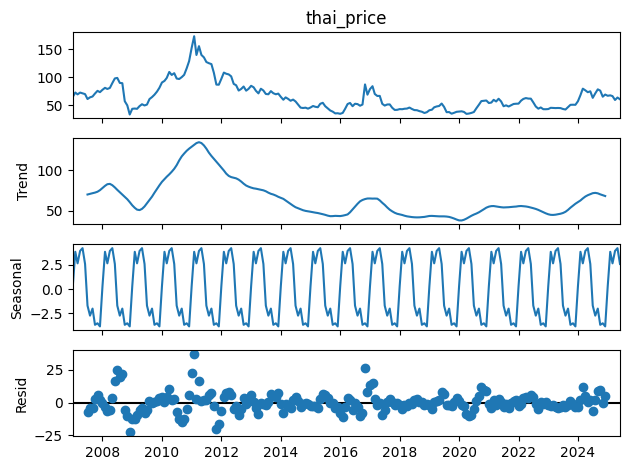

In [3]:
result = seasonal_decompose(df['thai_price'], model='additive', period=12)
result.plot()
plt.show()

Available columns: ['domestic_consumption', 'import_volume', 'export_volume', 'stock', 'exchange_rate_usd', 'china_pmi', 'thai_price', 'oil_price_thb', 'world_price_thb_kg', 'month', 'quarter', 'year', 'is_season', 'thai_price_lag6', 'thai_price_lag12', 'world_price_thb_kg_lag6', 'world_price_thb_kg_lag12', 'oil_price_thb_lag6', 'oil_price_thb_lag12', 'china_pmi_lag6', 'china_pmi_lag12', 'stock_lag6', 'stock_lag12', 'thai_price_ma6', 'thai_price_std6', 'thai_price_ma12', 'thai_price_std12', 'world_price_thb_kg_ma6', 'world_price_thb_kg_std6', 'world_price_thb_kg_ma12', 'world_price_thb_kg_std12', 'oil_price_thb_ma6', 'oil_price_thb_std6', 'oil_price_thb_ma12', 'oil_price_thb_std12', 'china_pmi_ma6', 'china_pmi_std6', 'china_pmi_ma12', 'china_pmi_std12', 'thai_price_pct6', 'thai_price_pct12', 'world_price_thb_kg_pct6', 'world_price_thb_kg_pct12', 'oil_price_thb_pct6', 'oil_price_thb_pct12', 'exchange_rate_usd_pct6', 'exchange_rate_usd_pct12']
Selected external factors: ['world_price_thb

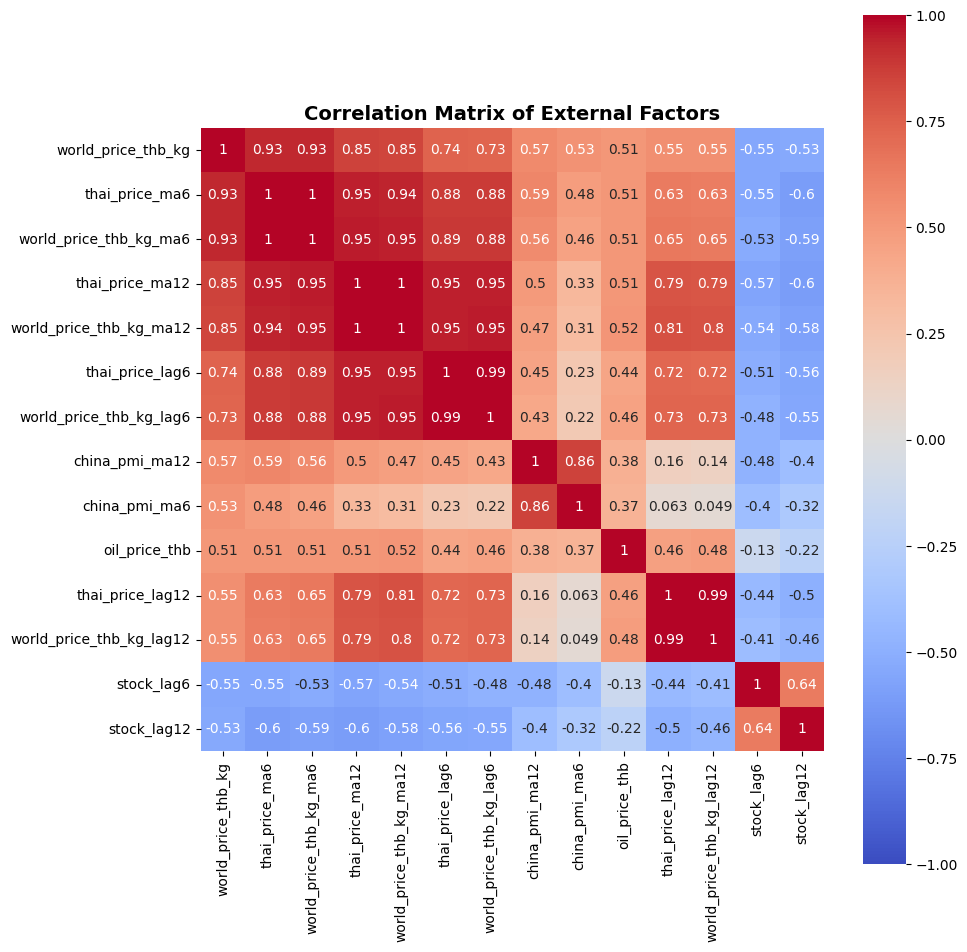

In [4]:
external_factors = [
    'world_price_thb_kg', 'thai_price_ma6', 'world_price_thb_kg_ma6', 'thai_price_ma12', 'world_price_thb_kg_ma12', 'thai_price_lag6', 'world_price_thb_kg_lag6',
    'china_pmi_ma12', 'china_pmi_ma6', 'oil_price_thb', 'thai_price_lag12', 'world_price_thb_kg_lag12', 'stock_lag6', 'stock_lag12'
]

print("Available columns:", df.columns.tolist())
print("Selected external factors:", [c for c in external_factors if c in df.columns])
print()

# เตรียม X, y
train_exog = train_data[external_factors].copy()
test_exog  = test_data[external_factors].copy()

X_train = train_exog.copy()
X_test  = test_exog.copy()
y_train = train_data['thai_price']
y_test  = test_data['thai_price']

mean_trp = y_train.mean()
print(f"Mean thai_price (train): {mean_trp:.4f}")
print("X_train:", X_train.shape, " X_test:", X_test.shape)

# Correlation matrix ของ external factors
corr = train_exog.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True
)
plt.title("Correlation Matrix of External Factors", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [5]:
full_train = train_data[['thai_price'] + external_factors].copy()
full_test  = test_data[['thai_price'] + external_factors].copy()

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(full_train)
test_scaled  = scaler.transform(full_test)

WINDOW = 12

def create_seq(data, win=WINDOW):
    X, y = [], []
    for i in range(len(data)-win):
        X.append(data[i:i+win, :])
        y.append(data[i+win, 0])
    return np.array(X), np.array(y)


X_train, y_train = create_seq(train_scaled)
X_test, y_test   = create_seq(test_scaled)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


X_train: (192, 12, 15)
X_test : (6, 12, 15)


In [6]:
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False,
         input_shape=(WINDOW, X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,593 (88.25 KB)

 Trainable params: 22,593 (88.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[es],
    verbose=1
)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0413 - val_loss: 0.0072
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0144 - val_loss: 0.0014
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0106 - val_loss: 0.0013
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0146 - val_loss: 0.0013
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0098 - val_loss: 0.0012
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0075 - val_loss: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0092 - val_loss: 8.8601e-04
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0085 - val_loss: 8.5929e-04
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0091 - val_loss: 0.0023
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0108 - val_loss: 9.1028e-04
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0075 - val_loss: 9.5541e-04
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━

In [8]:
pred_scaled = model.predict(X_test)

dummy = np.zeros((len(pred_scaled), train_scaled.shape[1]))
dummy[:,0] = pred_scaled[:,0]

pred = scaler.inverse_transform(dummy)[:,0]
actual = test_data['thai_price'].iloc[WINDOW:].values

rmse_before = np.sqrt(mean_squared_error(actual, pred))
mape_before = mean_absolute_percentage_error(actual, pred)*100

print("=== BEFORE MODEL (Baseline LSTM) ===")
print(f"RMSE : {rmse_before:.4f}")
print(f"MAPE : {mape_before:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
=== BEFORE MODEL (Baseline LSTM) ===
RMSE : 11.1414
MAPE : 16.58%


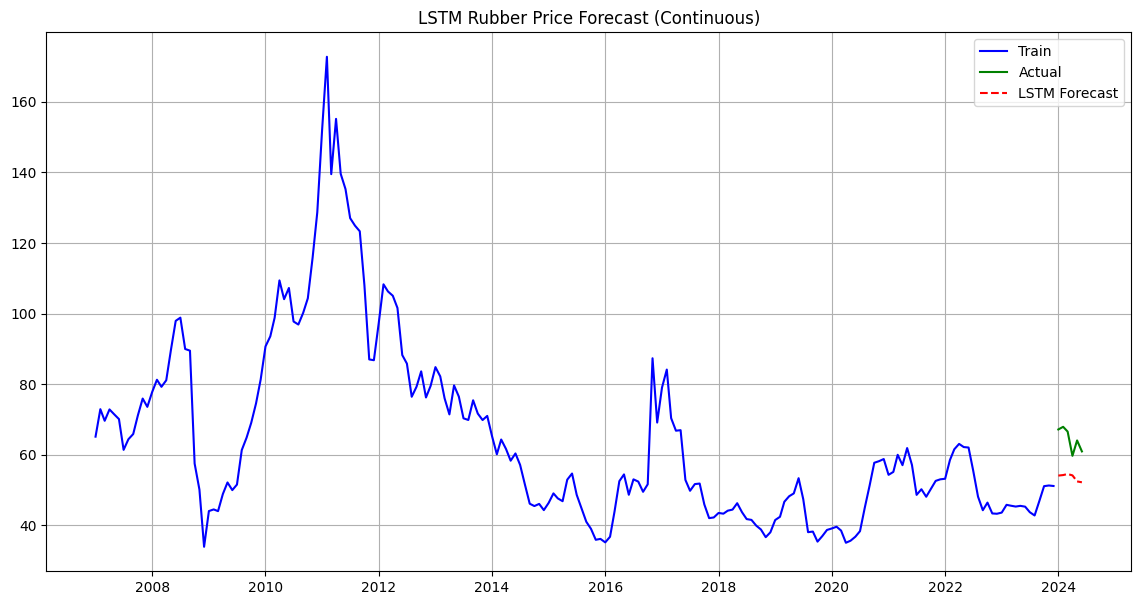

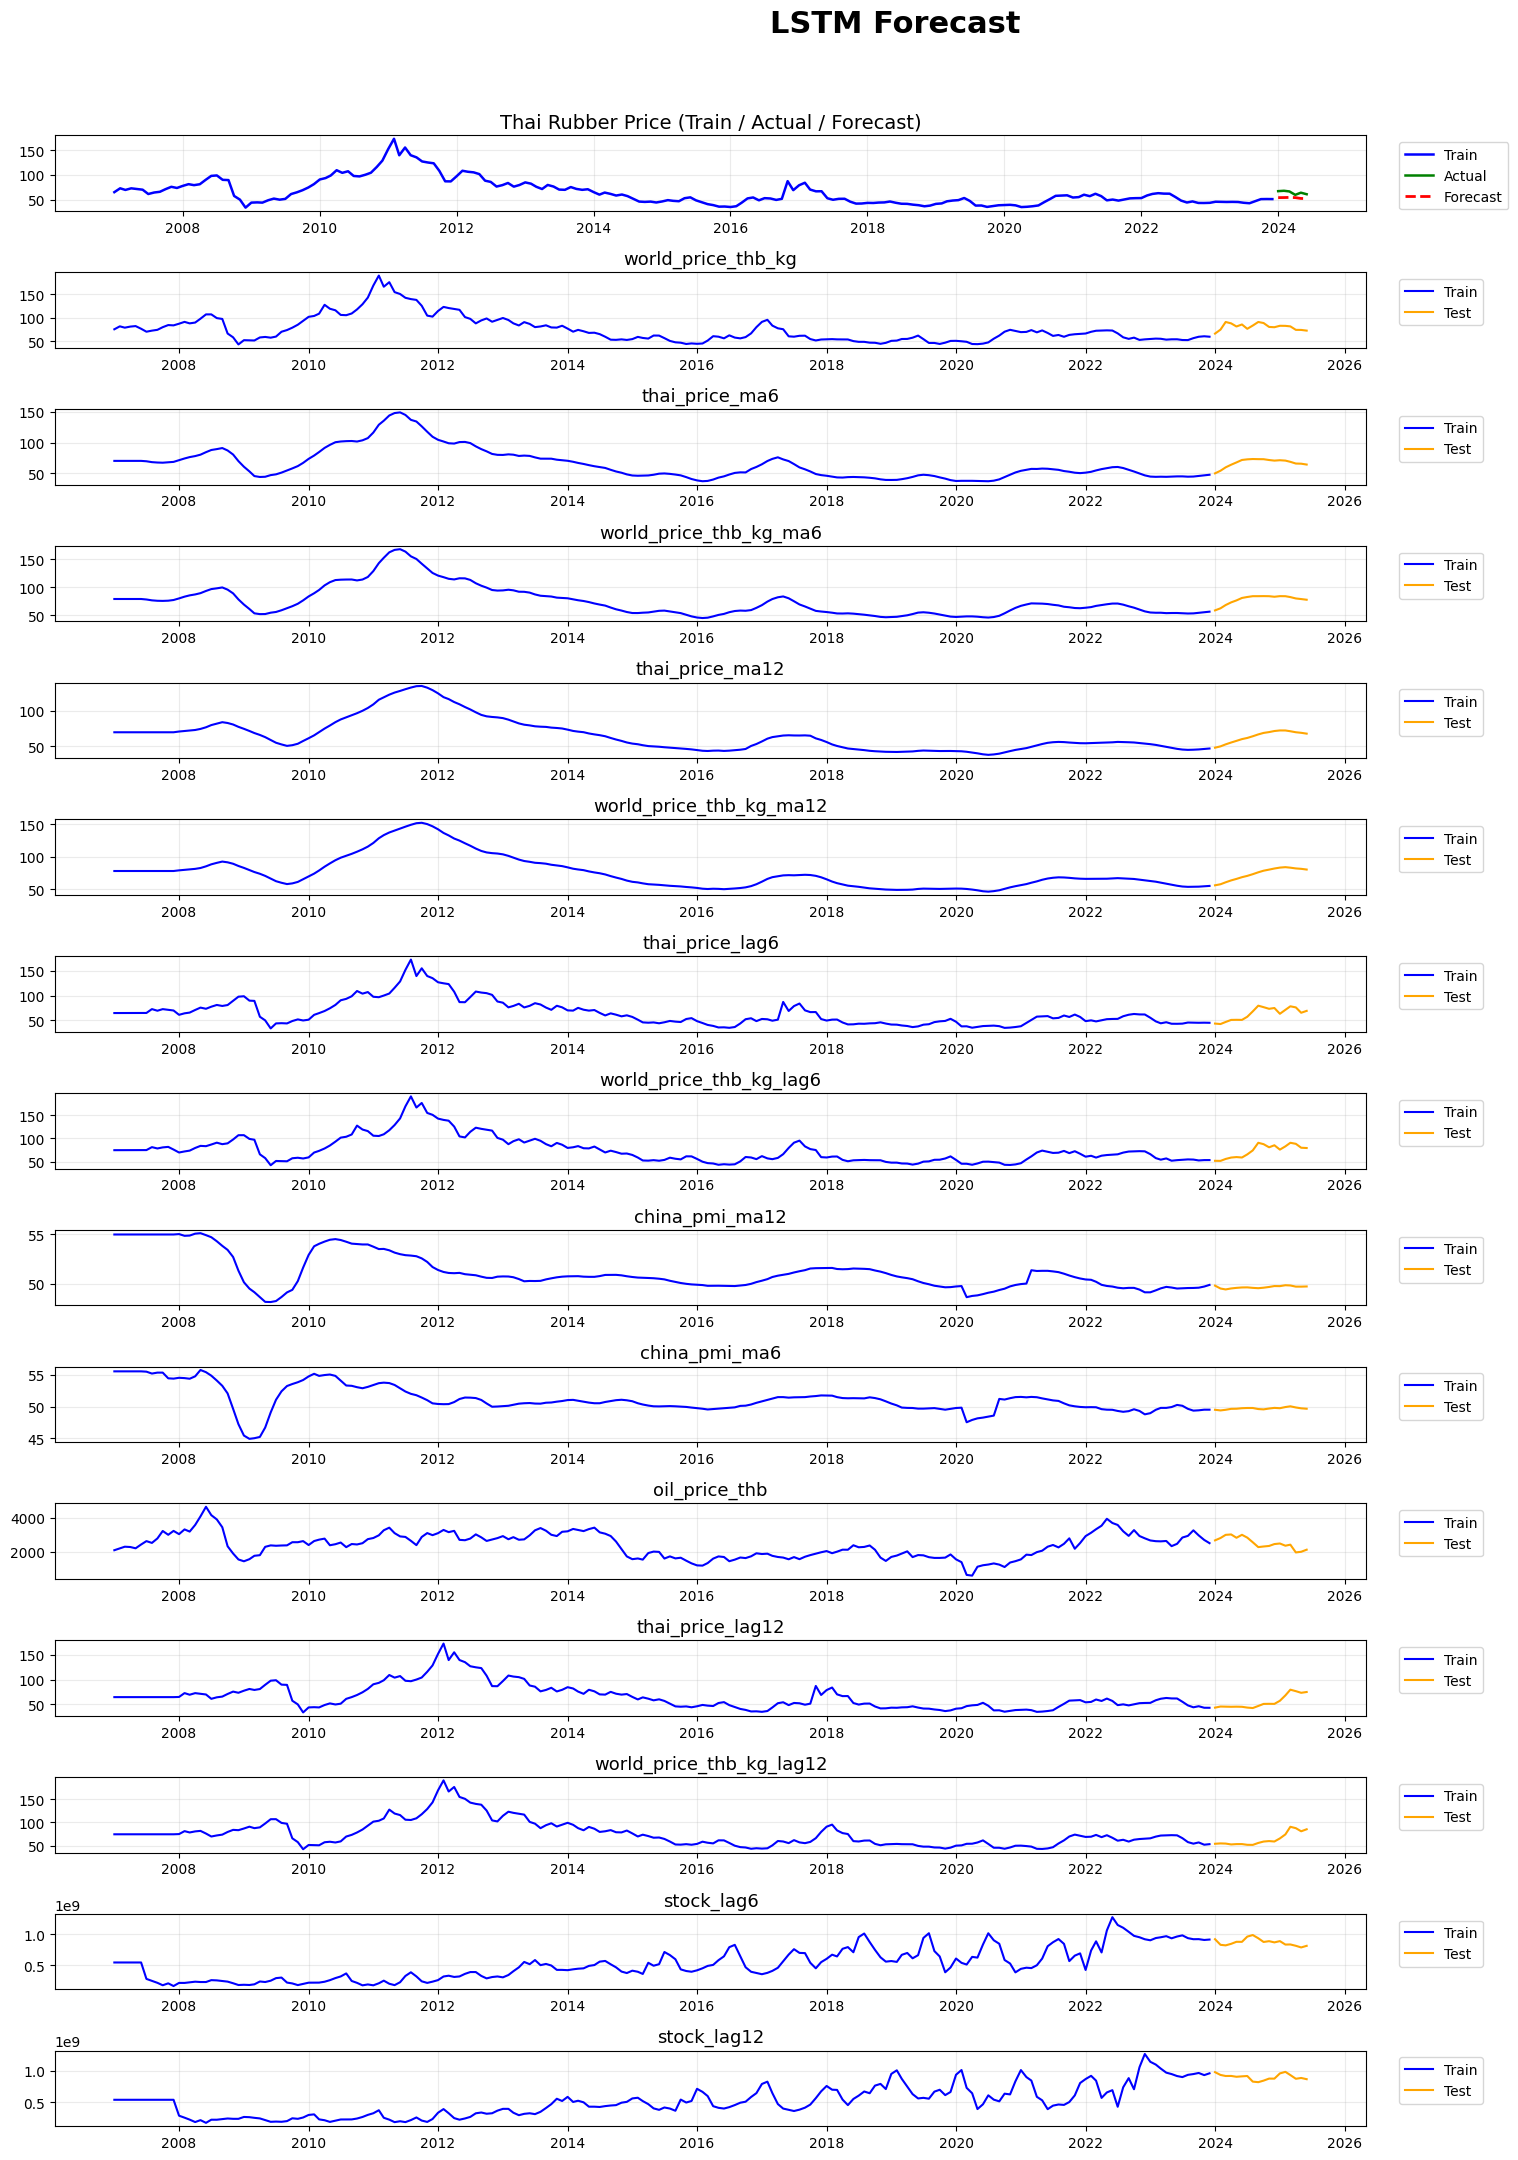

In [ ]:
pred_index = pd.date_range(
    start=train_data.index[-1] + pd.offsets.MonthBegin(1),
    periods=len(pred),
    freq='MS'
)

plt.figure(figsize=(14,7))

plt.plot(train_data.index, train_data['thai_price'], label='Train', color='blue')

plt.plot(test_data.index[:len(actual)], actual, label='Actual', color='green')

plt.plot(pred_index, pred, label='LSTM Forecast', color='red', linestyle='--')

plt.title("LSTM Rubber Price Forecast (Continuous)")
plt.grid(True)
plt.legend()
plt.show()



pred_index = pd.date_range(
    start=train_data.index[-1] + pd.offsets.MonthBegin(1),
    periods=len(pred),
    freq='MS'
)


fig, axes = plt.subplots(len(external_factors)+1, 1, figsize=(18, 22))

fig.suptitle("LSTM Forecast", fontsize=22, fontweight='bold')

plt.subplots_adjust(hspace=0.45)

ax0 = axes[0]

ax0.plot(train_data.index, train_data['thai_price'], label='Train', color='blue', linewidth=1.8)
ax0.plot(test_data.index[:len(actual)], actual, color='green', label='Actual', linewidth=1.8)
ax0.plot(pred_index, pred, color='red', label='Forecast', linestyle='--', linewidth=2.0)

ax0.set_title("Thai Rubber Price (Train / Actual / Forecast)", fontsize=14)
ax0.grid(True, alpha=0.25)

ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

for i, fac in enumerate(external_factors):
    ax = axes[i+1]

    ax.plot(train_data.index, train_data[fac], color='blue', label='Train', linewidth=1.5)
    ax.plot(test_data.index, test_data[fac], color='orange', label='Test', linewidth=1.5)

    ax.set_title(fac, fontsize=13)
    ax.grid(True, alpha=0.25)

    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()



Parameter Optimization (Optuna)

In [14]:
import optuna

def objective_lstm(trial):
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    dense_units = trial.suggest_int('dense_units', 16, 64)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    model = Sequential([
        LSTM(lstm_units, 
             activation='tanh', 
             return_sequences=False,
             input_shape=(WINDOW, X_train.shape[2])
            ),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    pred_scaled = model.predict(X_test)
    dummy = np.zeros((len(pred_scaled), train_scaled.shape[1]))
    dummy[:,0] = pred_scaled[:,0]
    pred = scaler.inverse_transform(dummy)[:,0]
    actual = test_data['thai_price'].iloc[WINDOW:].values

    rmse = np.sqrt(mean_squared_error(actual, pred))
    return rmse


study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=60)

best_lstm_params = study_lstm.best_params
print("\nOPTUNA BEST PARAMS (LSTM)")
print(best_lstm_params)

[I 2025-11-27 00:58:54,257] A new study created in memory with name: no-name-5f148235-441a-482a-9978-3c61bfdc6b75
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2025-11-27 00:59:00,209] Trial 0 finished with value: 11.596927886927322 and parameters: {'lstm_units': 69, 'dropout_rate': 0.3131385659318424, 'dense_units': 35, 'learning_rate': 0.0006432383398566244}. Best is trial 0 with value: 11.596927886927322.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2025-11-27 00:59:05,693] Trial 1 finished with value: 3.8575984000001946 and parameters: {'lstm_units': 95, 'dropout_rate': 0.33546775847586796, 'dense_units': 19, 'learning_rate': 0.00012761728824539498}. Best is trial 1 with value: 3.8575984000001946.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


[I 2025-11-27 00:59:12,433] Trial 2 finished with value: 2.98678240863025 and parameters: {'lstm_units': 52, 'dropout_rate': 0.36118009102528703, 'dense_units': 51, 'learning_rate': 0.0074143477029129535}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


[I 2025-11-27 00:59:16,726] Trial 3 finished with value: 3.383462387936032 and parameters: {'lstm_units': 59, 'dropout_rate': 0.3452175742766246, 'dense_units': 17, 'learning_rate': 0.00867337611936043}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2025-11-27 00:59:19,997] Trial 4 finished with value: 4.63182146488909 and parameters: {'lstm_units': 104, 'dropout_rate': 0.3587256024053639, 'dense_units': 46, 'learning_rate': 0.00023510402547907586}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2025-11-27 00:59:24,665] Trial 5 finished with value: 6.687273671601343 and parameters: {'lstm_units': 61, 'dropout_rate': 0.2546365057896361, 'dense_units': 44, 'learning_rate': 0.0011210283100333547}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


[I 2025-11-27 00:59:28,023] Trial 6 finished with value: 4.102709520217382 and parameters: {'lstm_units': 74, 'dropout_rate': 0.44130150118593103, 'dense_units': 61, 'learning_rate': 0.0015121029517614073}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2025-11-27 00:59:32,001] Trial 7 finished with value: 11.168803993119575 and parameters: {'lstm_units': 106, 'dropout_rate': 0.401797768014842, 'dense_units': 21, 'learning_rate': 0.0005227938061629858}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2025-11-27 00:59:35,411] Trial 8 finished with value: 13.318460847217187 and parameters: {'lstm_units': 73, 'dropout_rate': 0.4654320393368939, 'dense_units': 19, 'learning_rate': 0.00021142725715358177}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2025-11-27 00:59:39,989] Trial 9 finished with value: 3.692909050736384 and parameters: {'lstm_units': 89, 'dropout_rate': 0.30955283004894885, 'dense_units': 25, 'learning_rate': 0.0002100243150988173}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


[I 2025-11-27 00:59:45,725] Trial 10 finished with value: 6.5173381125664145 and parameters: {'lstm_units': 32, 'dropout_rate': 0.113045424616155, 'dense_units': 59, 'learning_rate': 0.008410658239909687}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


[I 2025-11-27 00:59:52,837] Trial 11 finished with value: 4.565248705292628 and parameters: {'lstm_units': 49, 'dropout_rate': 0.21451146686876868, 'dense_units': 50, 'learning_rate': 0.008454279684533526}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


[I 2025-11-27 00:59:56,532] Trial 12 finished with value: 12.234504910304576 and parameters: {'lstm_units': 48, 'dropout_rate': 0.4046809571507185, 'dense_units': 36, 'learning_rate': 0.0034494954523394458}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


[I 2025-11-27 01:00:05,486] Trial 13 finished with value: 6.049788210396161 and parameters: {'lstm_units': 124, 'dropout_rate': 0.23602536197412788, 'dense_units': 52, 'learning_rate': 0.003670939589011183}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


[I 2025-11-27 01:00:09,049] Trial 14 finished with value: 7.134135473431493 and parameters: {'lstm_units': 53, 'dropout_rate': 0.49206076401710963, 'dense_units': 28, 'learning_rate': 0.003781351897551331}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


[I 2025-11-27 01:00:12,726] Trial 15 finished with value: 12.67393994119494 and parameters: {'lstm_units': 38, 'dropout_rate': 0.38970364397950613, 'dense_units': 56, 'learning_rate': 0.002138821213085016}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


[I 2025-11-27 01:00:17,515] Trial 16 finished with value: 6.069265863786736 and parameters: {'lstm_units': 61, 'dropout_rate': 0.27121982268748723, 'dense_units': 39, 'learning_rate': 0.005593575518280564}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-11-27 01:00:23,690] Trial 17 finished with value: 4.591257545766835 and parameters: {'lstm_units': 41, 'dropout_rate': 0.18338168926228826, 'dense_units': 29, 'learning_rate': 0.009862630991922751}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


[I 2025-11-27 01:00:27,422] Trial 18 finished with value: 7.185171192414928 and parameters: {'lstm_units': 61, 'dropout_rate': 0.3609788976959052, 'dense_units': 45, 'learning_rate': 0.00254572271061534}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2025-11-27 01:00:31,041] Trial 19 finished with value: 6.58469648722614 and parameters: {'lstm_units': 88, 'dropout_rate': 0.28803129877394607, 'dense_units': 52, 'learning_rate': 0.005516247781386537}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


[I 2025-11-27 01:00:38,999] Trial 20 finished with value: 4.787831460393126 and parameters: {'lstm_units': 80, 'dropout_rate': 0.4394142635404744, 'dense_units': 64, 'learning_rate': 0.005236268359006324}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


[I 2025-11-27 01:00:42,390] Trial 21 finished with value: 16.339289291851593 and parameters: {'lstm_units': 88, 'dropout_rate': 0.31883775631975136, 'dense_units': 26, 'learning_rate': 0.0004357269104743065}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2025-11-27 01:00:45,923] Trial 22 finished with value: 12.254184658976607 and parameters: {'lstm_units': 55, 'dropout_rate': 0.3558835993368288, 'dense_units': 23, 'learning_rate': 0.00026430267317791126}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


[I 2025-11-27 01:00:51,542] Trial 23 finished with value: 8.914064543323517 and parameters: {'lstm_units': 67, 'dropout_rate': 0.29546576582946926, 'dense_units': 16, 'learning_rate': 0.00011124246814140442}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2025-11-27 01:00:54,908] Trial 24 finished with value: 10.868045962851689 and parameters: {'lstm_units': 85, 'dropout_rate': 0.3761907329796953, 'dense_units': 25, 'learning_rate': 0.0008266408222560648}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


[I 2025-11-27 01:00:58,665] Trial 25 finished with value: 6.619036114900536 and parameters: {'lstm_units': 103, 'dropout_rate': 0.32750032004935714, 'dense_units': 32, 'learning_rate': 0.0003499037304221944}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


[I 2025-11-27 01:01:02,845] Trial 26 finished with value: 5.332638788501761 and parameters: {'lstm_units': 117, 'dropout_rate': 0.19128920823508488, 'dense_units': 41, 'learning_rate': 0.0014826993484869527}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


[I 2025-11-27 01:01:06,076] Trial 27 finished with value: 4.946756821790893 and parameters: {'lstm_units': 79, 'dropout_rate': 0.4246816668103924, 'dense_units': 16, 'learning_rate': 0.0019252873191104348}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2025-11-27 01:01:09,264] Trial 28 finished with value: 13.591382130574013 and parameters: {'lstm_units': 42, 'dropout_rate': 0.27239303041911767, 'dense_units': 32, 'learning_rate': 0.00016541793984942475}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


[I 2025-11-27 01:01:12,543] Trial 29 finished with value: 5.963172753625607 and parameters: {'lstm_units': 69, 'dropout_rate': 0.3091301622654083, 'dense_units': 34, 'learning_rate': 0.0007626251785512836}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


[I 2025-11-27 01:01:19,560] Trial 30 finished with value: 4.3750388254017825 and parameters: {'lstm_units': 96, 'dropout_rate': 0.33915931210517175, 'dense_units': 38, 'learning_rate': 0.007180065298410427}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


[I 2025-11-27 01:01:24,629] Trial 31 finished with value: 5.844468021001854 and parameters: {'lstm_units': 97, 'dropout_rate': 0.3371880958321034, 'dense_units': 19, 'learning_rate': 0.00012099795463646145}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


[I 2025-11-27 01:01:29,033] Trial 32 finished with value: 3.414629429119754 and parameters: {'lstm_units': 112, 'dropout_rate': 0.3713616232611988, 'dense_units': 22, 'learning_rate': 0.00013705737999793898}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


[I 2025-11-27 01:01:32,291] Trial 33 finished with value: 5.744845342617849 and parameters: {'lstm_units': 113, 'dropout_rate': 0.3698778454147335, 'dense_units': 23, 'learning_rate': 0.00017148376727601694}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


[I 2025-11-27 01:01:38,102] Trial 34 finished with value: 8.203152533598464 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3444555652787503, 'dense_units': 22, 'learning_rate': 0.0003148148903871661}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


[I 2025-11-27 01:01:42,166] Trial 35 finished with value: 12.302335787653261 and parameters: {'lstm_units': 114, 'dropout_rate': 0.4200163852632236, 'dense_units': 28, 'learning_rate': 0.00015648752085823322}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


[I 2025-11-27 01:01:46,404] Trial 36 finished with value: 8.030834026401415 and parameters: {'lstm_units': 63, 'dropout_rate': 0.30703133566293056, 'dense_units': 19, 'learning_rate': 0.00010046925762563345}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


[I 2025-11-27 01:01:49,722] Trial 37 finished with value: 3.326196171627965 and parameters: {'lstm_units': 55, 'dropout_rate': 0.38256253180686073, 'dense_units': 48, 'learning_rate': 0.0011135364046514942}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


[I 2025-11-27 01:01:54,282] Trial 38 finished with value: 8.350099569589716 and parameters: {'lstm_units': 57, 'dropout_rate': 0.38843572883508204, 'dense_units': 47, 'learning_rate': 0.0011689255123865008}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2025-11-27 01:01:57,406] Trial 39 finished with value: 8.985963410922746 and parameters: {'lstm_units': 48, 'dropout_rate': 0.4636764141115529, 'dense_units': 56, 'learning_rate': 0.002769431627870573}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


[I 2025-11-27 01:02:02,845] Trial 40 finished with value: 5.9618044560577825 and parameters: {'lstm_units': 74, 'dropout_rate': 0.4117825945869016, 'dense_units': 43, 'learning_rate': 0.0006049530744030132}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


[I 2025-11-27 01:02:06,402] Trial 41 finished with value: 7.284384814285844 and parameters: {'lstm_units': 51, 'dropout_rate': 0.3787796009640133, 'dense_units': 50, 'learning_rate': 0.0002071476646714493}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2025-11-27 01:02:10,593] Trial 42 finished with value: 11.233858158311415 and parameters: {'lstm_units': 45, 'dropout_rate': 0.35143437329159644, 'dense_units': 47, 'learning_rate': 0.00044661259274208847}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


[I 2025-11-27 01:02:14,254] Trial 43 finished with value: 4.608882724167273 and parameters: {'lstm_units': 35, 'dropout_rate': 0.25219513261746496, 'dense_units': 18, 'learning_rate': 0.007384692233741922}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-11-27 01:02:18,298] Trial 44 finished with value: 6.7010349287929944 and parameters: {'lstm_units': 102, 'dropout_rate': 0.3913829382041514, 'dense_units': 56, 'learning_rate': 0.0001385389035402783}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


[I 2025-11-27 01:02:24,697] Trial 45 finished with value: 3.1790144933030122 and parameters: {'lstm_units': 65, 'dropout_rate': 0.3150491899544264, 'dense_units': 21, 'learning_rate': 0.009974252003100254}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


[I 2025-11-27 01:02:29,262] Trial 46 finished with value: 6.793584217022071 and parameters: {'lstm_units': 65, 'dropout_rate': 0.328659315399333, 'dense_units': 50, 'learning_rate': 0.004492795774913833}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2025-11-27 01:02:33,166] Trial 47 finished with value: 6.393418362406502 and parameters: {'lstm_units': 73, 'dropout_rate': 0.10969705639480148, 'dense_units': 20, 'learning_rate': 0.006828352501594236}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


[I 2025-11-27 01:02:40,562] Trial 48 finished with value: 5.779077879928922 and parameters: {'lstm_units': 58, 'dropout_rate': 0.4400507922863316, 'dense_units': 42, 'learning_rate': 0.00983589507675593}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


[I 2025-11-27 01:02:50,135] Trial 49 finished with value: 5.060830028412126 and parameters: {'lstm_units': 58, 'dropout_rate': 0.3998232150040757, 'dense_units': 54, 'learning_rate': 0.004360402302657081}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


[I 2025-11-27 01:02:57,912] Trial 50 finished with value: 6.726132607975086 and parameters: {'lstm_units': 69, 'dropout_rate': 0.3643905846719532, 'dense_units': 61, 'learning_rate': 0.0030279495681107566}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2025-11-27 01:03:02,895] Trial 51 finished with value: 4.838561968755199 and parameters: {'lstm_units': 51, 'dropout_rate': 0.2855396244271896, 'dense_units': 25, 'learning_rate': 0.006511504103374998}. Best is trial 2 with value: 2.98678240863025.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


[I 2025-11-27 01:03:08,885] Trial 52 finished with value: 2.984744917122969 and parameters: {'lstm_units': 80, 'dropout_rate': 0.316987869307295, 'dense_units': 21, 'learning_rate': 0.00826205955911945}. Best is trial 52 with value: 2.984744917122969.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


[I 2025-11-27 01:03:15,225] Trial 53 finished with value: 3.804367835596005 and parameters: {'lstm_units': 79, 'dropout_rate': 0.32125353889030606, 'dense_units': 21, 'learning_rate': 0.009539086374983102}. Best is trial 52 with value: 2.984744917122969.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


[I 2025-11-27 01:03:20,824] Trial 54 finished with value: 4.521254751104176 and parameters: {'lstm_units': 54, 'dropout_rate': 0.35475520819382456, 'dense_units': 16, 'learning_rate': 0.007876296708589815}. Best is trial 52 with value: 2.984744917122969.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


[I 2025-11-27 01:03:25,676] Trial 55 finished with value: 5.2388745272854536 and parameters: {'lstm_units': 44, 'dropout_rate': 0.2766770978988323, 'dense_units': 23, 'learning_rate': 0.005967919900843515}. Best is trial 52 with value: 2.984744917122969.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


[I 2025-11-27 01:03:30,161] Trial 56 finished with value: 6.250188630080607 and parameters: {'lstm_units': 84, 'dropout_rate': 0.2488954821940608, 'dense_units': 29, 'learning_rate': 0.004859701361160216}. Best is trial 52 with value: 2.984744917122969.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


[I 2025-11-27 01:03:37,605] Trial 57 finished with value: 4.2961815468216775 and parameters: {'lstm_units': 65, 'dropout_rate': 0.2994538736738361, 'dense_units': 18, 'learning_rate': 0.008212366344417415}. Best is trial 52 with value: 2.984744917122969.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


[I 2025-11-27 01:03:41,936] Trial 58 finished with value: 10.127252911780655 and parameters: {'lstm_units': 76, 'dropout_rate': 0.38393461056826067, 'dense_units': 48, 'learning_rate': 0.0021188667961469553}. Best is trial 52 with value: 2.984744917122969.
C:\Users\bankw\AppData\Local\Temp\ipykernel_25920\3297496010.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


[I 2025-11-27 01:03:46,772] Trial 59 finished with value: 15.916432666567337 and parameters: {'lstm_units': 92, 'dropout_rate': 0.3705882519474427, 'dense_units': 45, 'learning_rate': 0.003671039346553491}. Best is trial 52 with value: 2.984744917122969.



=== OPTUNA BEST PARAMS (LSTM) ===
{'lstm_units': 80, 'dropout_rate': 0.316987869307295, 'dense_units': 21, 'learning_rate': 0.00826205955911945}


In [15]:
after_lstm_model = Sequential([
    LSTM(best_lstm_params['lstm_units'], 
            activation='tanh', 
            return_sequences=False,
            input_shape=(WINDOW, X_train.shape[2])
        ),
    Dropout(best_lstm_params['dropout_rate']),
    Dense(best_lstm_params['dense_units'], activation='relu'),
    Dense(1)
])

after_optimiter = tf.keras.optimizers.Adam(learning_rate=best_lstm_params['learning_rate'])
after_es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

after_lstm_model.compile(optimizer=after_optimiter, loss='mse')
after_lstm_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=16,
    callbacks=[after_es],
    verbose=1
)

pred_scaled_after = after_lstm_model.predict(X_test)
dummy_after = np.zeros((len(pred_scaled_after), train_scaled.shape[1]))
dummy_after[:,0] = pred_scaled_after[:,0]

pred_after = scaler.inverse_transform(dummy_after)[:,0]
actual_after = test_data['thai_price'].iloc[WINDOW:].values

rmse_after = np.sqrt(mean_squared_error(actual_after, pred_after))
mape_after = mean_absolute_percentage_error(actual_after, pred_after)*100

print("=== AFTER MODEL (Optuna Tuned LSTM) ===")
print(f"RMSE : {rmse_after:.4f}")
print(f"MAPE : {mape_after:.2f}%")

Epoch 1/200


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1185 - val_loss: 0.0047
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - val_loss: 0.0013
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0139 - val_loss: 0.0029
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0135 - val_loss: 0.0011
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0097 - val_loss: 0.0034
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0109 - val_loss: 0.0022
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0097 - val_loss: 0.0019
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0073 - val_loss: 0.0031
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0079 - val_loss: 0.0029
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071 - val_loss: 0.0027
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070

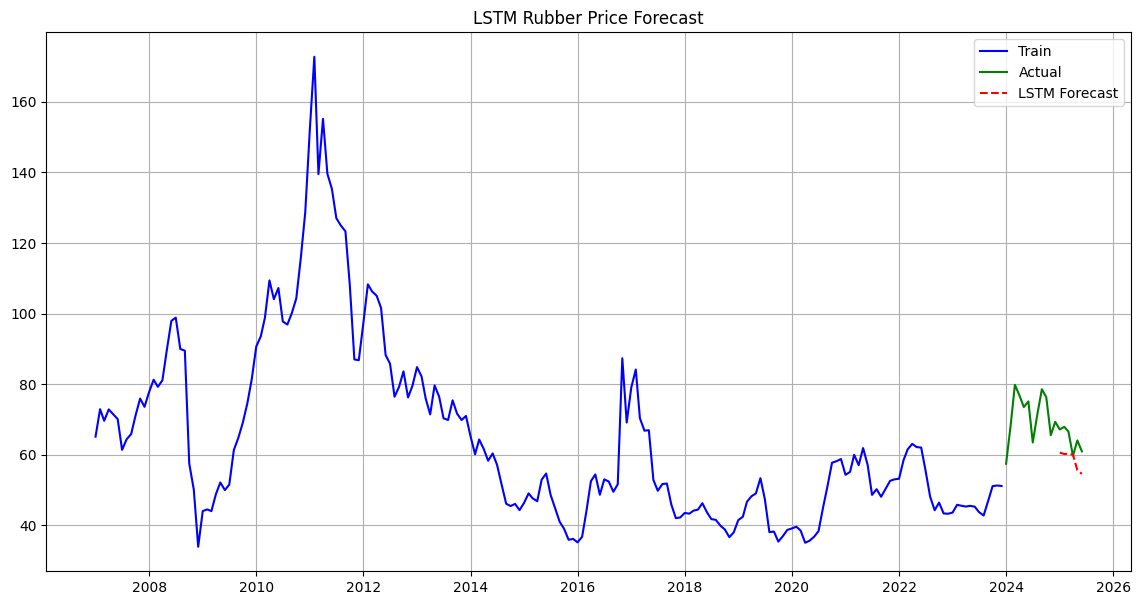

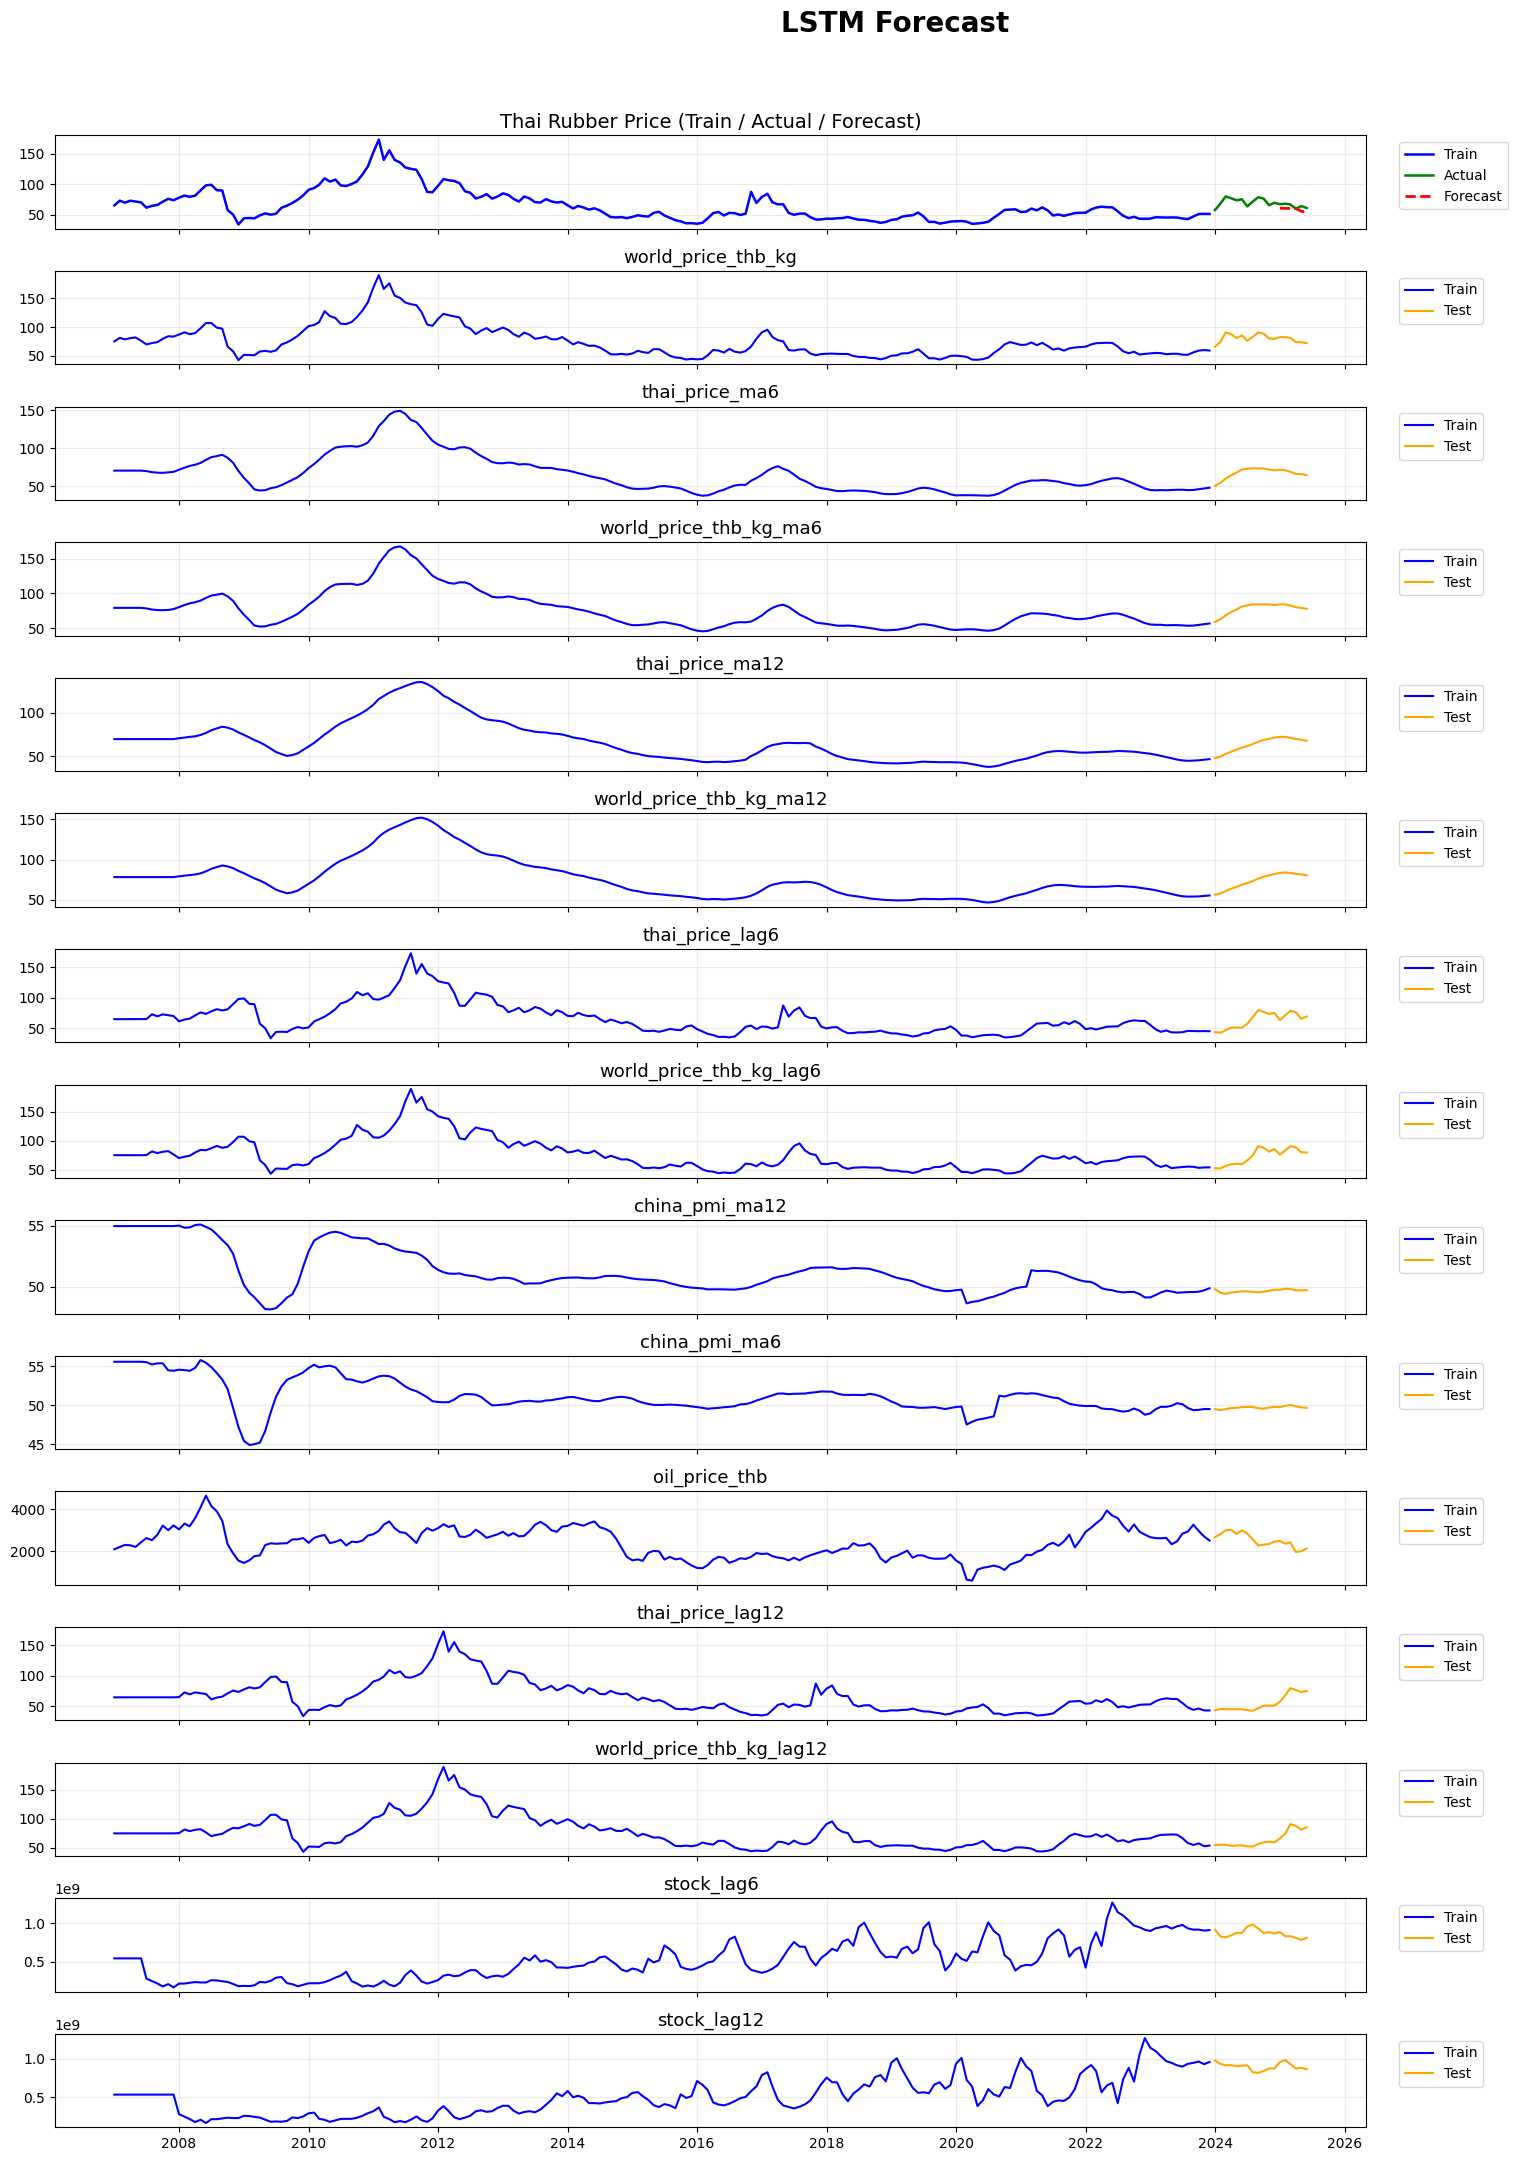

In [ ]:
pred_after_index = test_data.index[-len(pred_after):]
actual_after = test_data['thai_price'].values

plt.figure(figsize=(14,7))

plt.plot(train_data.index, train_data['thai_price'], label='Train', color='blue')
plt.plot(test_data.index, actual_after, label='Actual', color='green')

plt.plot(pred_after_index, pred_after, label='LSTM Forecast', color='red', linestyle='--')

plt.title("LSTM Rubber Price Forecast")
plt.grid(True)
plt.legend()
plt.show()


# ปรับ layout ให้โปรขึ้น / ห่างกันมากขึ้น
fig, axes = plt.subplots(
    len(external_factors) + 1,
    1,
    figsize=(18, 22),
    sharex=True
)

fig.suptitle("LSTM Forecast", fontsize=20, fontweight='bold')
plt.subplots_adjust(hspace=0.45)

axes[0].plot(train_data.index,
             train_data['thai_price'],
             label='Train',
             color='blue',
             linewidth=1.8)

axes[0].plot(test_data.index,
             actual_after,
             color='green',
             label='Actual',
             linewidth=1.8)

axes[0].plot(pred_after_index,
             pred_after,
             color='red',
             label='Forecast',
             linestyle='--',
             linewidth=2.0)

axes[0].set_title("Thai Rubber Price (Train / Actual / Forecast)", fontsize=14)
axes[0].grid(True, alpha=0.25)
axes[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1))

for i, fac in enumerate(external_factors):
    ax = axes[i + 1]
    ax.plot(train_data.index,
            train_data[fac],
            color='blue',
            label='Train',
            linewidth=1.5)
    ax.plot(test_data.index,
            test_data[fac],
            color='orange',
            label='Test',
            linewidth=1.5)

    ax.set_title(fac, fontsize=13)
    ax.grid(True, alpha=0.25)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()



In [18]:
def compute_score(rmse, mape, mean_trp, w_rmse=0.5, w_mape=0.5):
    """
    Unified Score 0–100 จาก RMSE และ MAPE
    """
    nrmse = rmse / mean_trp        # Normalize ด้วย mean ของ TRP
    mape_norm = mape / 100.0
    score = 100 * (1 - (w_rmse*nrmse + w_mape*mape_norm))
    return max(0, min(100, score))

score_before = compute_score(rmse_before, mape_before, mean_trp)
score_after  = compute_score(rmse_after,  mape_after,  mean_trp)

summary_df = pd.DataFrame({
    "Model": ["Before (Baseline Ridge)", "After (Optuna Ridge)"],
    "RMSE": [rmse_before, rmse_after],
    "MAPE (%)": [mape_before, mape_after],
    "Score (0-100)": [score_before, score_after]
})

print("=== COMPARISON: BEFORE vs AFTER (LSTM) ===")
print(summary_df.to_string(index=False))


=== COMPARISON: BEFORE vs AFTER (LSTM) ===
                  Model      RMSE  MAPE (%)  Score (0-100)
Before (Baseline Ridge) 11.141425 16.576152       83.08544
   After (Optuna Ridge)  6.506235  9.126440       90.39919


PCA + LSTM

In [19]:
print("\nPCA + LSTM")

approach_pca_lstm = []

scaler2 = StandardScaler()
train_scaled2 = scaler2.fit_transform(train_exog)
test_scaled2  = scaler2.transform(test_exog)

def seq_lstm(data, win=12):
    X, y = [], []
    for i in range(len(data)-win):
        X.append(data[i:i+win,:])
        y.append(data[i+win,0])
    return np.array(X), np.array(y)


for n_comp in range(2,10):

    pca = PCA(n_components=n_comp)
    train_pca = pca.fit_transform(train_scaled2)
    test_pca  = pca.transform(test_scaled2)

    explained = pca.explained_variance_ratio_.sum()

    #full matrix TRP + PCs
    train_full = np.concatenate([train_data[['thai_price']].values, train_pca], axis=1)
    test_full  = np.concatenate([test_data[['thai_price']].values, test_pca], axis=1)

    Xtr, ytr = seq_lstm(train_full)
    Xte, yte = seq_lstm(test_full)

    mdl = Sequential([
        LSTM(64, activation='tanh', return_sequences=False,
             input_shape=(12, train_full.shape[1])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    mdl.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    mdl.fit(
        Xtr, ytr,
        validation_split=0.1,
        epochs=100,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    pred_unscaled = mdl.predict(Xte, verbose=0)

    # The model predicts unscaled TRP values, so no inverse transformation is needed.
    pred = pred_unscaled[:,0]

    rmse = np.sqrt(mean_squared_error(yte, pred))
    mape = mean_absolute_percentage_error(yte, pred)*100

    print(f"{n_comp} comp | Var={explained*100:.1f}% | RMSE={rmse:.4f} | MAPE={mape:.2f}%")

    approach_pca_lstm.append({
        "n_components": n_comp,
        "explained_var": explained,
        "RMSE": rmse,
        "MAPE": mape,
        "pred": pred,
        "true": yte
    })

best_pca_lstm = min(approach_pca_lstm, key=lambda x: x["RMSE"])

print("\n===== Best PCA+LSTM ====")
print("Components:", best_pca_lstm["n_components"])
print("Expl.Var :", best_pca_lstm["explained_var"]*100)
print("RMSE     :", best_pca_lstm["RMSE"])
print("MAPE     :", best_pca_lstm["MAPE"])


PCA + LSTM


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2 comp | Var=78.9% | RMSE=4.2491 | MAPE=5.51%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3 comp | Var=86.3% | RMSE=17.0445 | MAPE=25.83%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4 comp | Var=91.4% | RMSE=18.6442 | MAPE=28.36%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5 comp | Var=94.3% | RMSE=17.3455 | MAPE=26.32%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6 comp | Var=96.8% | RMSE=14.4474 | MAPE=21.72%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7 comp | Var=98.9% | RMSE=14.7986 | MAPE=22.27%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8 comp | Var=99.5% | RMSE=18.1334 | MAPE=27.56%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9 comp | Var=99.8% | RMSE=4.4727 | MAPE=6.34%

===== Best PCA+LSTM ====
Components: 2
Expl.Var : 78.9439664672021
RMSE     : 4.249050555635185
MAPE     : 5.511926196195466


Data Visualization

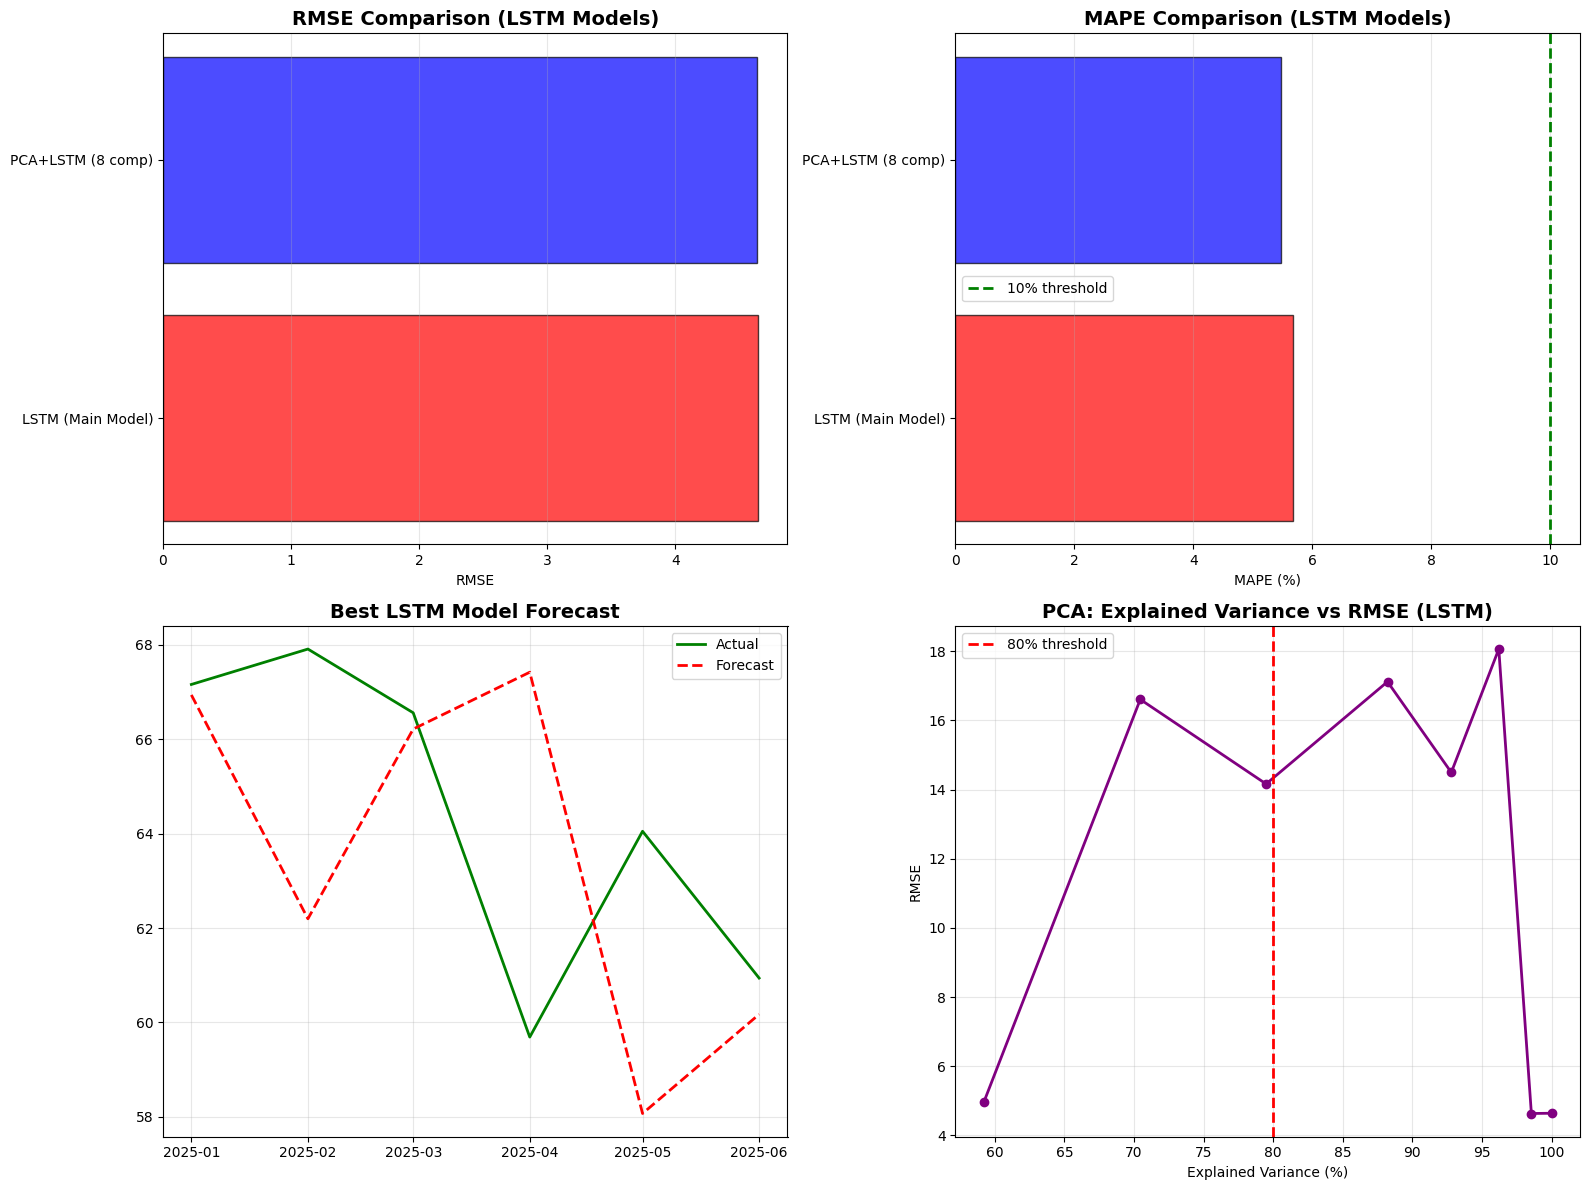

In [ ]:
import matplotlib.pyplot as plt

#เทียบเฉพาะ LSTM Main + PCA+LSTM
all_approaches = [
    {
        "Method": "LSTM (Main Model)",
        "RMSE": rmse,
        "MAPE": mape
    },
    {
        "Method": f"PCA+LSTM ({best_pca_lstm['n_components']} comp)",
        "RMSE": best_pca_lstm['RMSE'],
        "MAPE": best_pca_lstm['MAPE']
    }
]

methods = [a["Method"] for a in all_approaches]
rmse_vals = [a["RMSE"] for a in all_approaches]
mape_vals = [a["MAPE"] for a in all_approaches]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#RMSE Comparison
ax = axes[0, 0]
ax.barh(methods, rmse_vals, color=['red', 'blue'], alpha=0.7, edgecolor='black')
ax.set_title("RMSE Comparison (LSTM Models)", fontsize=14, fontweight='bold')
ax.set_xlabel("RMSE")
ax.grid(True, axis='x', alpha=0.3)


#MAPE Comparison
ax = axes[0, 1]
ax.barh(methods, mape_vals, color=['red', 'blue'], alpha=0.7, edgecolor='black')
ax.axvline(x=10, color='green', linestyle='--', linewidth=2, label='10% threshold')
ax.set_title("MAPE Comparison (LSTM Models)", fontsize=14, fontweight='bold')
ax.set_xlabel("MAPE (%)")
ax.legend()
ax.grid(True, axis='x', alpha=0.3)

#Best Model Forecast
best_overall = (
    best_pca_lstm
    if best_pca_lstm["RMSE"] < rmse
    else {"pred": pred, "true": actual}
)

ax = axes[1, 0]
#กรณีเป็น PCA+LSTM
if "true" in best_overall:
    ax.plot(
        test_data.index[WINDOW:],
        best_overall["true"],
        label="Actual",
        color="green",
        linewidth=2
    )
    ax.plot(
        test_data.index[WINDOW:],
        best_overall["pred"],
        label="Forecast",
        color="red",
        linestyle="--",
        linewidth=2
    )
else:
    #ถ้าเป็น main LSTM
    ax.plot(
        test_data.index[WINDOW:], actual, label='Actual', color='green', linewidth=2)
    ax.plot(
        test_data.index[WINDOW:], pred, label='Forecast', color='red', linestyle='--', linewidth=2)

ax.set_title("Best LSTM Model Forecast", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

#PCA vs RMSE Curve
ax = axes[1, 1]
exp_vars = [r['explained_var']*100 for r in approach_pca_lstm]
rmse_vals_pca = [r['RMSE'] for r in approach_pca_lstm]

ax.plot(exp_vars, rmse_vals_pca, marker='o', color='purple', linewidth=2)
ax.axvline(x=80, linestyle='--', color='red', linewidth=2, label='80% threshold')

ax.set_xlabel("Explained Variance (%)")
ax.set_ylabel("RMSE")
ax.set_title("PCA: Explained Variance vs RMSE (LSTM)", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
data = {
    'Model': ['Baseline (LSTM)', 'Optuna LSTM'],
    'RMSE': [rmse_before, rmse_after],
    'MAPE': [mape_before/100, mape_after/100],
    'ACCURACY': [score_before/100, score_after/100]
}

df_comparison = pd.DataFrame(data)

df_comparison['MAPE (%)'] = (df_comparison['MAPE'] * 100).map('{:.2f}%'.format)
df_comparison['ACCURACY (%)'] = (df_comparison['ACCURACY'] * 100).map('{:.2f}%'.format)

df_display = df_comparison[['Model', 'RMSE', 'MAPE (%)', 'ACCURACY (%)']]

print("Performance Comparison (LSTM)\n")
print(df_display.to_string(index=True, col_space=15))

Performance Comparison (LSTM)

                           Model            RMSE        MAPE (%)    ACCURACY (%)
0                Baseline (LSTM)        9.428791          13.48%          85.96%
1                    Optuna LSTM        5.132526           5.78%          93.14%
